# Классификация записей при помощи CNN: эксперименты с моделями

## Необходимые библиотеки

In [1]:
!pip install daze

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os, sklearn, torch, optuna, daze
import numpy as np, pandas as pd, wandb as wb, matplotlib.pyplot as plt, seaborn as sns

from torch import nn
from optuna.integration.wandb import WeightsAndBiasesCallback

In [5]:
from google.colab import drive
drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/HSE/GTZAN/Data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
seed = 42
random_state = np.random.RandomState(seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
import warnings
warnings.filterwarnings('ignore')
os.environ['WANDB_SILENT'] = 'true'

## Загрузка данных

Загрузим предварительно сохраненные данные в датасет и сопоставим музывальным жанрам номера с помощью LabelEncoder.

In [8]:
classes = ('blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock')
n_classes = len(classes)

label_encoder = sklearn.preprocessing.LabelEncoder()
label_encoder.fit(classes)

LabelEncoder()

In [9]:
class GTZAN(torch.utils.data.Dataset):

    def __init__(self, split, encoder, main_path=data_path):
        root_path = os.path.join(main_path, "prepared_data", split)
        data_path = os.path.join(root_path, 'data')
        self.data_files = [os.path.join(data_path, item) for item in os.listdir(data_path)]
        self.data_files.sort(key=self.get_id)
        self.labels = pd.read_csv(os.path.join(root_path, 'labels.csv'), index_col=0, squeeze=True)
        self.encoder = encoder
        
    def get_id(self, file):
        return int(os.path.splitext(os.path.basename(file))[0])
           
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        filename = self.data_files[index]
        
        # загрузим признаки
        x = torch.load(filename)
        
        # сопоставим классу цифру
        label = self.labels.iloc[index]
        y = self.encoder.transform([label]).item()
        
        return x, y

In [10]:
n_features = 12
train_set = GTZAN('train', label_encoder)
val_set = GTZAN('val', label_encoder)
test_set = GTZAN('test', label_encoder)


## Архитектура сверточной нейронной сети

Вся сеть будет состоять из двух блоков:

1.   Сверточные слои: 4 последовательно идущих сверточных слоя с Batch-normalization и ReLU в качестве функции активации.
2.   Полносвязные слои: 3 полносвязных слоя, LogSoftmax для классификации.





In [11]:
class ConvolutionalBlock(nn.Module):
    def __init__(self, n_channels, channel_widths):
        super().__init__()
        
        self.model = nn.ModuleDict({
            'conv1': nn.Sequential(
                nn.LazyConv2d(n_channels[0], kernel_size=(8, channel_widths[0]), stride=(3, 4), padding=(11, 4)),
                nn.BatchNorm2d(n_channels[0]),
                nn.ReLU(),
            ),
            'conv2': nn.Sequential(
                nn.LazyConv2d(n_channels[1], kernel_size=(6, channel_widths[1]), stride=(2, 3), padding=(4, 3)),
                nn.BatchNorm2d(n_channels[1]),
                nn.ReLU(),
            ),
            'conv3': nn.Sequential(
                nn.LazyConv2d(n_channels[2], kernel_size=(4, channel_widths[2]), stride=(1, 2), padding=(0, 2)),
                nn.BatchNorm2d(n_channels[2]),
                nn.ReLU(),
            ),
            'conv4': nn.Sequential(
                nn.LazyConv2d(n_channels[3], kernel_size=(3, channel_widths[3]), stride=(1, 1), padding=(0, 1)),
                nn.BatchNorm2d(n_channels[3]),
                nn.ReLU(),
            ),
            'flatten': nn.Flatten()
        })
        
        
    def forward(self, x):
  
        for i in range(1, 5):
            x = self.model[f'conv{i}'](x)
            
        return self.model['flatten'](x)

In [12]:
class ClassificationBlock(nn.Module):
    def __init__(self, n_classes, n_linear, dropout):
        super().__init__()
        
        self.model = nn.ModuleDict({
            'fc1': nn.Sequential(
                nn.LazyLinear(n_linear[0]),
                nn.ReLU(),
                nn.Dropout(dropout[0])
            ),
            'fc2': nn.Sequential(
                nn.LazyLinear(n_linear[1]),
                nn.ReLU(),
                nn.Dropout(dropout[1])
            ),
            'fc3': nn.Sequential(
                nn.LazyLinear(n_linear[2]),
                nn.ReLU(),
                nn.Dropout(dropout[2])
            ),
            'softmax': nn.Sequential(
                nn.LazyLinear(n_classes),
                nn.LogSoftmax(dim=1)
            )
        })
        
    def forward(self, x):
        for i in range(1, 4):
            x = self.model[f'fc{i}'](x)
            
        return self.model['softmax'](x)

Объединим эти два блока вместе.

In [13]:
class GTZANCNN(nn.Module):
    def __init__(self, n_classes, n_channels, channel_widths, n_linear, dropout):
        super().__init__()
        
        self.model = nn.ModuleDict({
            'conv_block': ConvolutionalBlock(n_channels, channel_widths),
            'clf_block': ClassificationBlock(n_classes, n_linear, dropout)
        })
        
    def forward(self, x):
        x = self.model['conv_block'](x)
        return self.model['clf_block'](x)


Для того, чтобы модель не переобучалась, будем делать early stop - если в течение некоторого количества итераций (patience) loss не уменьшается, заканчиваем тренировать модель. 

Ссылка на репозиторий с исходным кодом: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py

In [14]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path=None, trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str or None): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        if self.path is not None:
            torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

Тренируем модель

In [15]:
def train(model, optimizer, criterion, train_gen, val_gen):
    n_epochs = 100
    
    # сохраняем loss 
    avg_train_losses, avg_val_losses = [], []
    
    # сохраняем accuracy
    train_accuracies, val_accuracies = [], []
    
    # ииинициализируем Early Stop
    early_stopping = EarlyStopping(patience=10, verbose=False)
    
    for epoch in range(n_epochs):
        # тренируем модель
        model.train()
        train_correct, train_losses = [], []
        for i, (batch, labels) in enumerate(train_gen):
            # выбираем среду выполнения
            batch, labels = batch.to(device), labels.to(device)
            # зануляем градиенты
            optimizer.zero_grad()
            # считаем предсказания
            log_prob = model(batch)
            y_pred = torch.argmax(log_prob, dim=1)
            # считаем loss, делаем backpropogation
            train_loss = criterion(log_prob, labels)
            train_losses.append(train_loss.item())
            train_loss.backward()
            # считаем количество верных предсказаний
            train_correct.append(labels == y_pred)
            # обновляем оптимизатор
            optimizer.step()
            
        # считаем средние метрики
        avg_train_losses.append(torch.Tensor(train_losses).mean().item())
        train_accuracies.append(torch.cat(train_correct).float().mean().item())

        # валидация
        model.eval()
        val_correct, val_losses = [], []
        with torch.no_grad():
            for i, (batch, labels) in enumerate(val_gen):
                # выбираем среду выполнения
                batch, labels = batch.to(device), labels.to(device)
                # считаем предсказания
                log_prob = model(batch)
                y_pred = torch.argmax(log_prob, dim=1)
                # считаем loss
                val_loss = criterion(log_prob, labels)
                val_losses.append(val_loss.item())
                ## считаем количество верных предсказаний
                val_correct.append(labels == y_pred)
                
        # считаем средние метрики
        avg_val_losses.append(torch.Tensor(val_losses).mean().item())
        val_accuracies.append(torch.cat(val_correct).float().mean().item())
        
        # если никаких улучшений - заканчиваем
        early_stopping(avg_val_losses[epoch], model)
        if early_stopping.early_stop:
            break
        
    return avg_train_losses, avg_val_losses, train_accuracies, val_accuracies, epoch + 1

## Эксперименты

В ходе исследования методов решения задачи был найден инструмент, позволяющий удобно проводить оптимизацию гиперпараметров сети - [Optuna](https://optuna.org/). 

Попробуем менять количество каналов, ширину ядра (таким образом захватывая больше или меньше фреймов в одной свертке), количество нейронов в полносвязных сетях и вероятность выбросить нейрон в Dropout. Также будем менять learning rate и weight decay в оптимайзере Adam.

In [16]:
def objective(trial):
    # количество каналов
    n_channels = (
        trial.suggest_categorical('conv1_depth', (32, 64)),
        trial.suggest_categorical('conv2_depth', (64, 128)),
        trial.suggest_categorical('conv3_depth', (128, 256)),
        trial.suggest_categorical('conv4_depth', (256, 512)),
    )
    
    # ширина ядра
    channel_widths = (
        trial.suggest_categorical('conv1_width', (16, 32)),
        trial.suggest_categorical('conv2_width', (8, 16)),
        trial.suggest_categorical('conv3_width', (4, 8)),
        trial.suggest_categorical('conv4_width', (2, 4)),
    )
    
    # количество нейронов для полносвязных слоев
    n_linear = (
        trial.suggest_categorical('fc1', (256, 512)),
        trial.suggest_categorical('fc2', (128, 256)),
        trial.suggest_categorical('fc3', (64, 128))
    )
    
    # вероятность Dropout
    dropout = (
        trial.suggest_uniform('p1', 0.1, 0.8),
        trial.suggest_uniform('p2', 0.1, 0.8),
        trial.suggest_uniform('p3', 0.1, 0.8),
    )
    
    # гиперпараметры для optimizer
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-7, 1e-3)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-7, 1e-3)
    
    # Initialize the model and send it to GPU
    model = GTZANCNN(n_classes, n_channels, channel_widths, n_linear, dropout).to(device)
    trial.set_user_attr(key='model', value=model)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.NLLLoss()
    
    train_gen = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True, num_workers=2)
    val_gen = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=True, num_workers=2)

    avg_train_losses, avg_val_losses, train_accuracies, val_accuracies, epochs = train(model, optimizer, criterion, train_gen, val_gen)
    
    trial.set_user_attr(key='train_losses', value=avg_train_losses)
    trial.set_user_attr(key='val_losses', value=avg_val_losses)
    trial.set_user_attr(key='train_accuracies', value=train_accuracies)
    trial.set_user_attr(key='val_accuracies', value=val_accuracies)
    trial.set_user_attr(key='epochs', value=epochs)

    return avg_val_losses[-1]

И используем Optima для нахождения лучшей модели.

In [17]:
# Create a new Optuna study for hyper-parameter optimization
sampler = optuna.samplers.TPESampler(seed=seed)
study = optuna.create_study(direction='minimize', sampler=sampler)

# W&B integration - Initializes a new job for keeping track of hyper-parameter optimization
wb_callback = WeightsAndBiasesCallback(metric_name='val_loss', wandb_kwargs={'project': 'gtzan-cnn', 'name': 'final-search'})

# Callback to save the model that had the best Optuna trial
def model_callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key='best_model', value=trial.user_attrs['model'])

# Run the hyper-parameter search
study.optimize(objective, n_trials=25, show_progress_bar=True, callbacks=[wb_callback, model_callback])
wb.finish()

[I 2022-06-23 01:55:49,419] A new study created in memory with name: no-name-c6a5d3b2-01bc-4835-953a-430de36749a8


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2022-06-23 01:57:38,465] Trial 0 finished with value: 1.5206555128097534 and parameters: {'conv1_depth': 64, 'conv2_depth': 64, 'conv3_depth': 128, 'conv4_depth': 512, 'conv1_width': 32, 'conv2_width': 16, 'conv3_width': 4, 'conv4_width': 4, 'fc1': 512, 'fc2': 128, 'fc3': 64, 'p1': 0.3045012539746528, 'p2': 0.35645329030558426, 'p3': 0.4192489889519252, 'learning_rate': 0.0001382623217936986, 'weight_decay': 6.290644294586138e-07}. Best is trial 0 with value: 1.5206555128097534.
[I 2022-06-23 02:00:34,004] Trial 1 finished with value: 1.6894868612289429 and parameters: {'conv1_depth': 64, 'conv2_depth': 128, 'conv3_depth': 128, 'conv4_depth': 512, 'conv1_width': 16, 'conv2_width': 16, 'conv3_width': 4, 'conv4_width': 2, 'fc1': 256, 'fc2': 128, 'fc3': 128, 'p1': 0.22939811886786896, 'p2': 0.778709239435191, 'p3': 0.6425929763527802, 'learning_rate': 0.0005727904470799618, 'weight_decay': 0.0003795853142670637}. Best is trial 0 with value: 1.5206555128097534.
[I 2022-06-23 02:04:44,77

Параметры лучшей модели

In [18]:
# Fetch the best trial and model
trial = study.best_trial
model = study.user_attrs['best_model']

# Display model configuration
print(f'NLL (Val): {trial.value}')
print('Configuration: ')
for key, value in trial.params.items():
    print(f'\t{key}: {value}')

print("Best model:")
print(model)

NLL (Val): 1.0930436849594116
Configuration: 
	conv1_depth: 32
	conv2_depth: 64
	conv3_depth: 256
	conv4_depth: 512
	conv1_width: 16
	conv2_width: 16
	conv3_width: 8
	conv4_width: 4
	fc1: 512
	fc2: 256
	fc3: 128
	p1: 0.14249052872213303
	p2: 0.5227745572428337
	p3: 0.5232298382880523
	learning_rate: 8.117633309269598e-06
	weight_decay: 7.261844128841559e-06
Best model:
GTZANCNN(
  (model): ModuleDict(
    (conv_block): ConvolutionalBlock(
      (model): ModuleDict(
        (conv1): Sequential(
          (0): Conv2d(6, 32, kernel_size=(8, 16), stride=(3, 4), padding=(11, 4))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (conv2): Sequential(
          (0): Conv2d(32, 64, kernel_size=(6, 16), stride=(2, 3), padding=(4, 3))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (conv3): Sequential(
          (0): Conv2d(64,

## Результаты

Посмотрим на то, как обучалась модель и какие у нее были метрики. Результаты будем сравнивать со статьей Gabriel Gessle and Simon Åkesson, A comparative analysis of CNN and LSTM for music genre classification
(https://www.diva-portal.org/smash/get/diva2:1354738/FULLTEXT01.pdf)


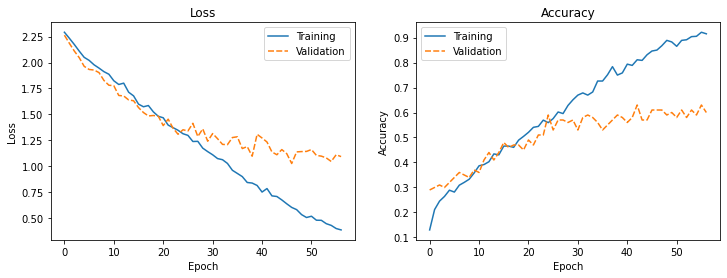

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(data=pd.DataFrame({
    'Training': trial.user_attrs['train_losses'], 
    'Validation': trial.user_attrs['val_losses']
}), ax=axs[0])
axs[0].set(title='Loss', xlabel='Epoch', ylabel='Loss')
axs[0].xaxis.get_major_locator().set_params(integer=True)

axs[1] = sns.lineplot(data=pd.DataFrame({
    'Training': trial.user_attrs['train_accuracies'], 
    'Validation': trial.user_attrs['val_accuracies']
}))
axs[1].set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')
axs[1].xaxis.get_major_locator().set_params(integer=True)

plt.show()

In [20]:
model.eval()

test_gen = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), num_workers=2)

batch, labels = next(iter(test_gen))
batch, labels = batch.to(device), labels.to(device)

y = model(batch)
y_pred = torch.argmax(y, dim=1)

torch.mean((labels == y_pred).float())

tensor(0.6600, device='cuda:0')

Таким образом, средняя accuracy равна 0.66, что превышает значение из статьи.

Посмотрим на то, как модель работает с разными классами.

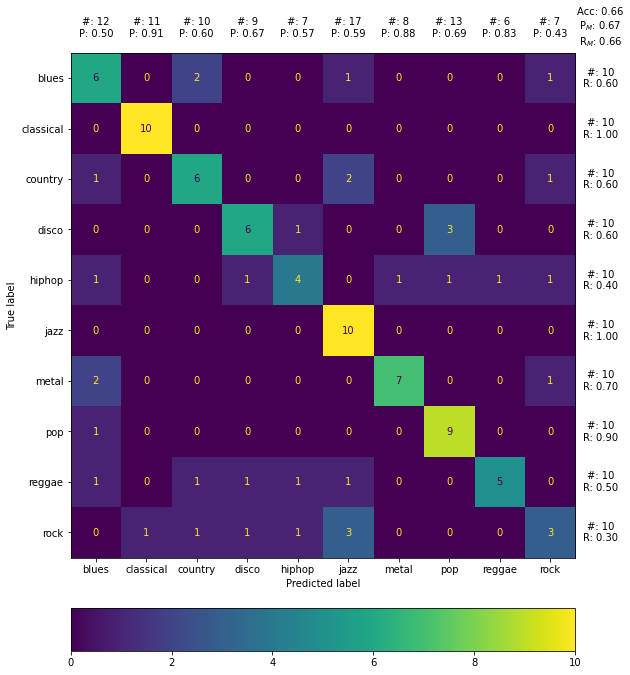

In [22]:
# Plot the test confusion matrix with per-class precision and recall values
fig, ax = plt.subplots(figsize=(11, 11))
true_val = labels.cpu().numpy()
pred_val = y_pred.cpu().numpy()
cm = sklearn.metrics.confusion_matrix(true_val, pred_val)
daze.plot_confusion_matrix(cm, measures=('a', 'c', 'p', 'r'), display_labels=classes, measures_format='.2f', ax=ax)
plt.show()


В теории можно послушать те аудиозаписи, которые модель классифицировала неправильно, и оценить, насколько они отличаются.

In [28]:
names = pd.read_csv(os.path.join(data_path, 'prepared_data', "test", 'filenames.csv'))
names["true"] = true_val
names["predicted"] = pred_val
names.drop(names.index[true_val == pred_val])

,Unnamed: 0,filename,true,predicted
4,4,rock.00063.wav,9,4
6,6,disco.00021.wav,3,7
9,9,hiphop.00098.wav,4,6
10,10,country.00067.wav,2,0
13,13,country.00043.wav,2,9
14,14,blues.00002.wav,0,2
19,19,blues.00097.wav,0,2
22,22,pop.00010.wav,7,0
25,25,country.00054.wav,2,5
26,26,reggae.00015.wav,8,0
